# Binary Classification Predictive Modelling

In [18]:
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/2-Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8, 6]  
plt.rcParams['figure.dpi'] = 100  

### Data Preview

In [19]:
print(data.head())

   id  age      dist       income gender marital_status  target
0   1   73  4.371654    90-99,999      M              S       1
1   2   89  1.582733  100-149,999      M            NaN       1
2   3   85  1.223810    10-19,999      F              S       1
3   4   76  2.962427    90-99,999      M              M       1
4   5   76  2.594408    10-19,999      M              S       1


### Prepare Data

#### Predictors
- income from categorical to continuous variable by assigning midpoint of the range as integer (income level char: "90-99,999" --> int: 95,000)
- age and distance as integer 
- gender, marital_status as binary

#### Response
- target as binary

In [20]:
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

income_mapping = {
    "unknown": 55000,
    "Under $10k": 5000,
    "10-19,999": 15000,
    "20-29,999": 25000,
    "30-39,999": 35000,
    "40-49,999": 45000,
    "50-59,999": 55000,
    "60-69,999": 65000,
    "70-79,999": 75000,
    "80-89,999": 85000,
    "90-99,999": 95000,
    "100-149,999": 125000,
    "150 - 174,999": 162500,
    "175 - 199,999": 187500,
    "200 - 249,999": 225000,
    "250k+": 250000
}
data["income"] = data["income"].map(income_mapping).astype(int)

gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

data["target"] = data["target"].astype(int)

data["dist"] = data["dist"].astype(int)

In [21]:
print(data.head())

   id  age  dist  income  gender  marital_status  target
0   1   73     4   95000       1               0       1
1   2   89     1  125000       1               1       1
2   3   85     1   15000       0               0       1
3   4   76     2   95000       1               1       1
4   5   76     2   15000       1               0       1


#### Examine individual strength of continuous predictors within data set by plotting observed probability of response corresponding to predictor values.   

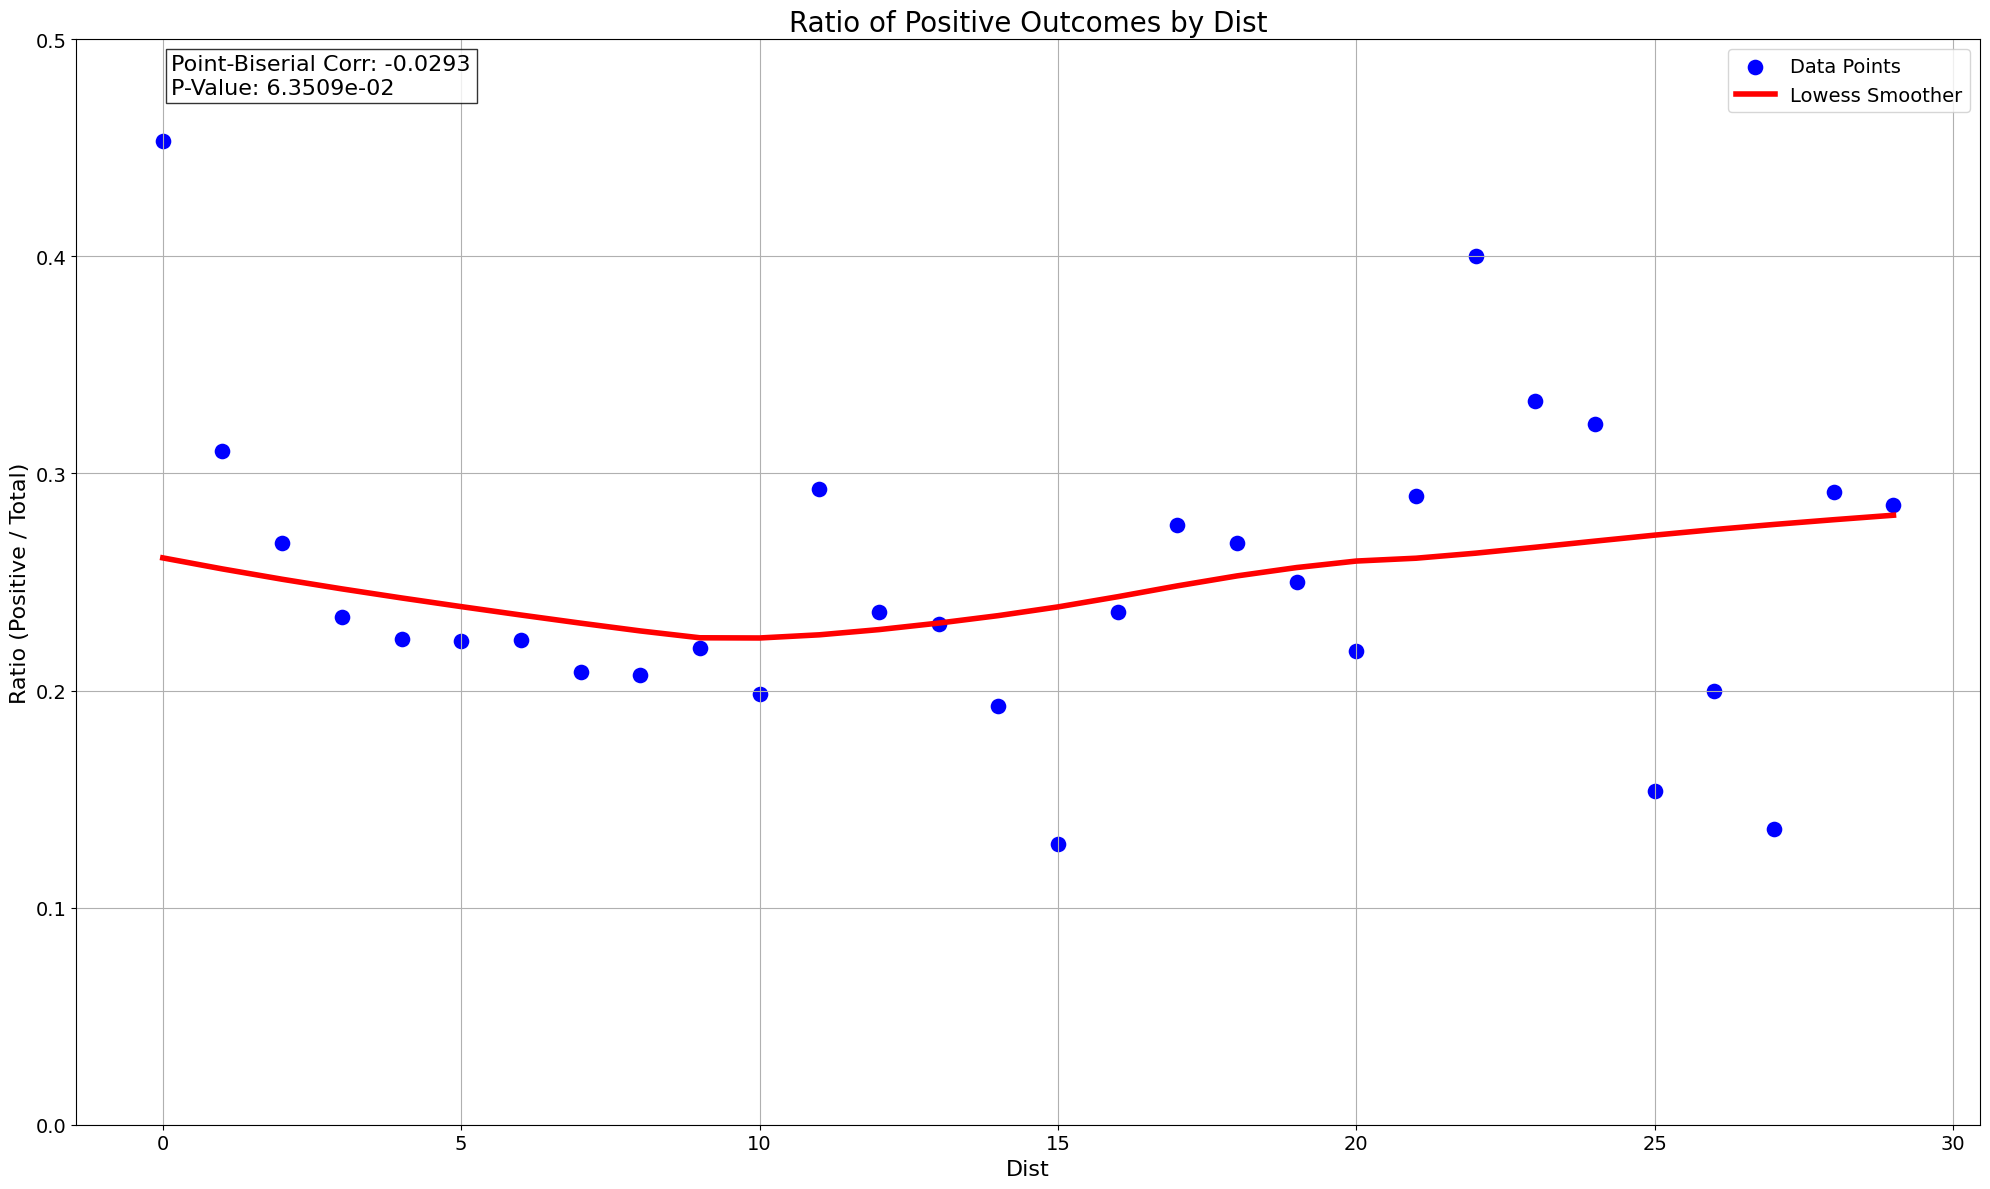

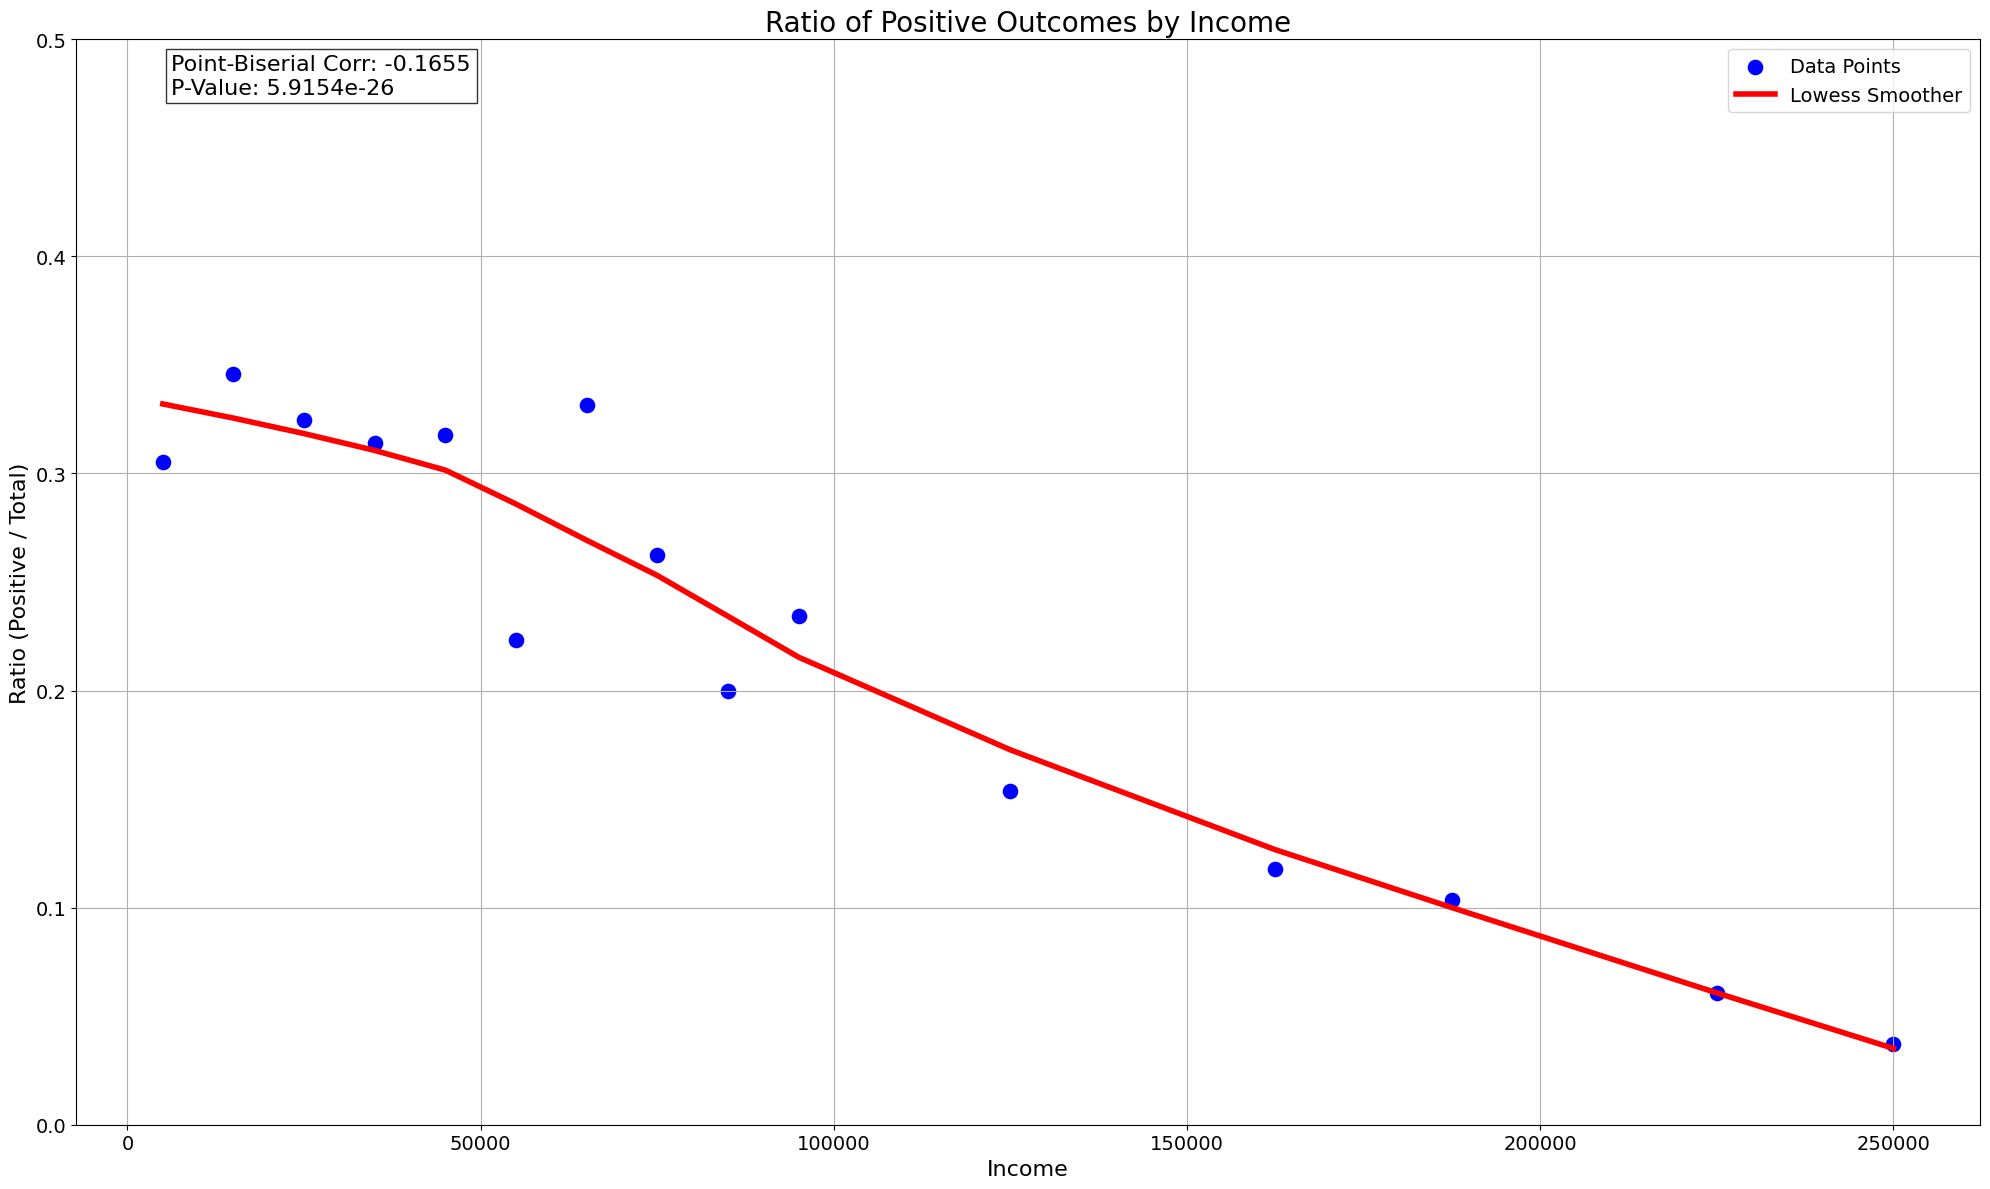

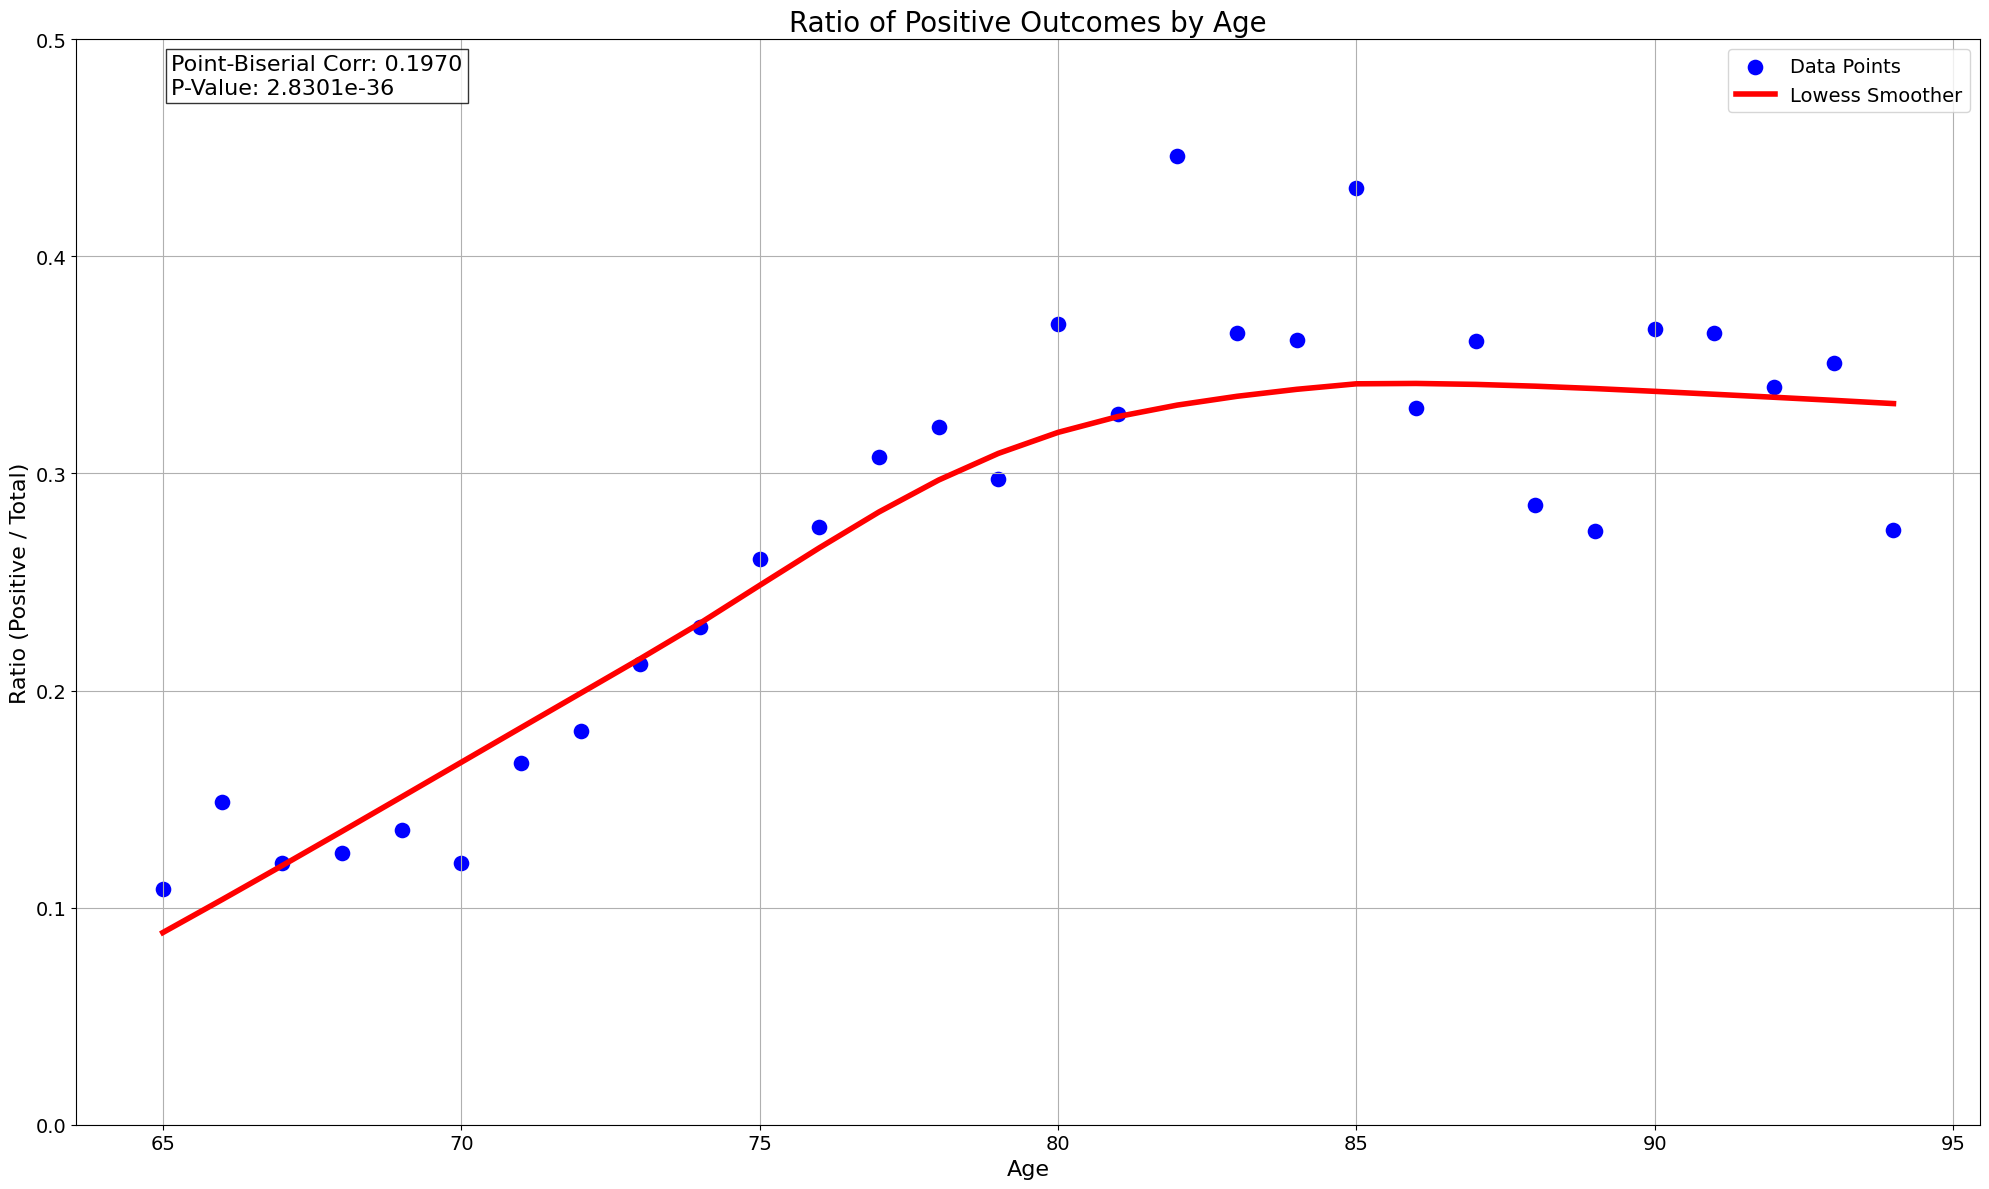

In [22]:
import seaborn as sns
from scipy.stats import pointbiserialr


def make_plot(df, var, ax, threshold=None):
    plot_df, corr, p = plot_ratio_positive_negative_with_corr(df, var, 'target')
    sns.scatterplot(x=var, y='ratio_positive_negative', data=plot_df, color='blue', s=150, label='Data Points', ax=ax)
    
    if threshold:
        df_below = plot_df[plot_df[var] <= threshold]
        df_above = plot_df[plot_df[var] > threshold]
        sns.regplot(x=var, y='ratio_positive_negative', data=df_below, scatter=False,
                   lowess=True, color='red', line_kws={'lw': 4}, 
                   label=f'Lowess Smoother (≤{threshold})', ax=ax)
        sns.regplot(x=var, y='ratio_positive_negative', data=df_above, scatter=False,
                   lowess=True, color='green', line_kws={'lw': 4}, 
                   label=f'Lowess Smoother (>{threshold})', ax=ax)
    else:
        sns.regplot(x=var, y='ratio_positive_negative', data=plot_df, scatter=False,
                   lowess=True, color='red', line_kws={'lw': 4}, label='Lowess Smoother', ax=ax)
    
    ax.text(0.05, 0.95, f'Point-Biserial Corr: {corr:.4f}\nP-Value: {p:.4e}', 
            transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(f'Ratio of Positive Outcomes by {var.title()}', fontsize=20)
    ax.set_xlabel(var.title(), fontsize=16)
    ax.set_ylabel('Ratio (Positive / Total)', fontsize=16)
    ax.set_ylim(0, 0.50)
    ax.legend(fontsize=14)
    ax.grid(True)
    ax.tick_params(labelsize=14)

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    ratio = pivot[positive_value] / (pivot[positive_value] + pivot[negative_value] + 1e-9)
    plot_df = pd.DataFrame({continuous_var: ratio.index, 'ratio_positive_negative': ratio.values})
    return plot_df, *pointbiserialr(df[continuous_var], df[categorical_var])


for var in ['dist', 'income', 'age']:
    fig, ax = plt.subplots(figsize=(20, 12))
    make_plot(data, var, ax)
    plt.tight_layout()
    plt.show()

Continuous predictors appear to have mixed effects, visualize significance of change in variable effect by plotting with separate smoother.

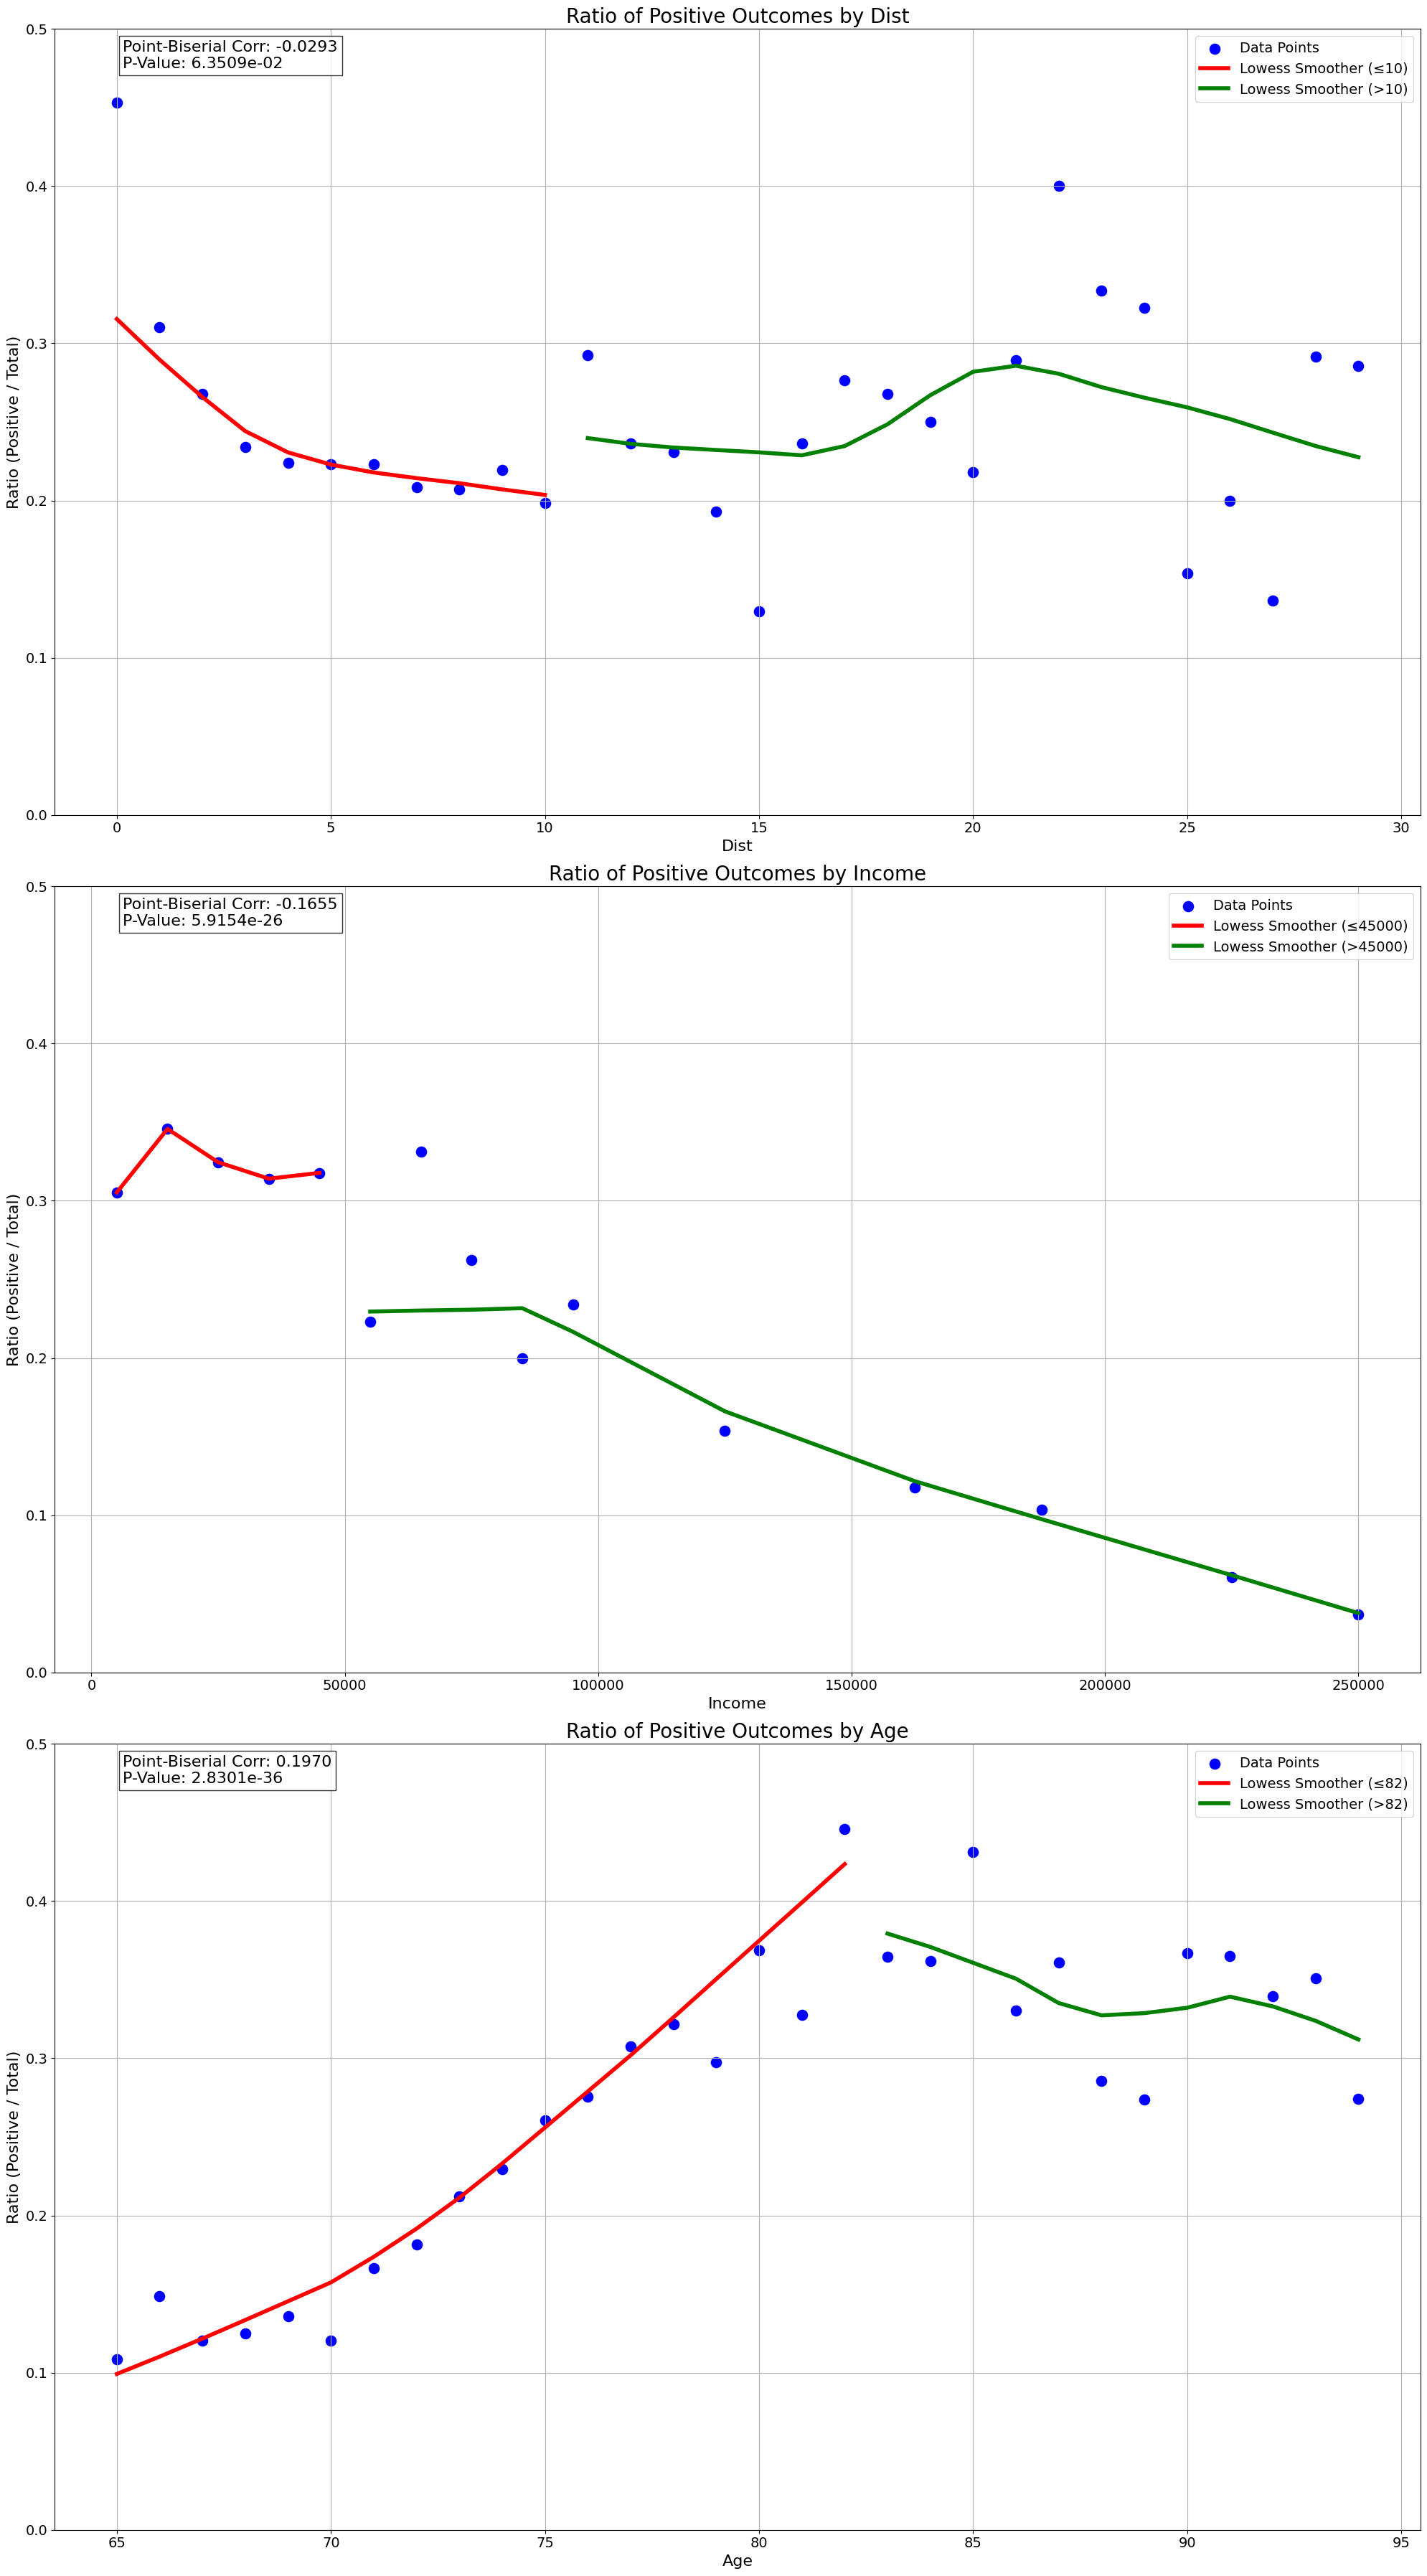

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 36))
make_plot(data, 'dist', ax1, threshold=10)
make_plot(data, 'income', ax2, threshold=45000)
make_plot(data, 'age', ax3, threshold=82)
plt.tight_layout()
plt.show()

Age and Income have most visually apparent change in relationship to response.

In model testing, only accounting for the mixed effects of variable age provided significant increase in model performance. 

In [24]:
import numpy as np
data['age_lt80'] = np.where(data['age'] < 80, data['age'], 80)
data['age_ge80'] = np.where(data['age'] >= 80, data['age'] - 80, 0)
print(data.head())

   id  age  dist  income  gender  marital_status  target  age_lt80  age_ge80
0   1   73     4   95000       1               0       1        73         0
1   2   89     1  125000       1               1       1        80         9
2   3   85     1   15000       0               0       1        80         5
3   4   76     2   95000       1               1       1        76         0
4   5   76     2   15000       1               0       1        76         0


Examine strength of categorical predictors and check for interactions between them.

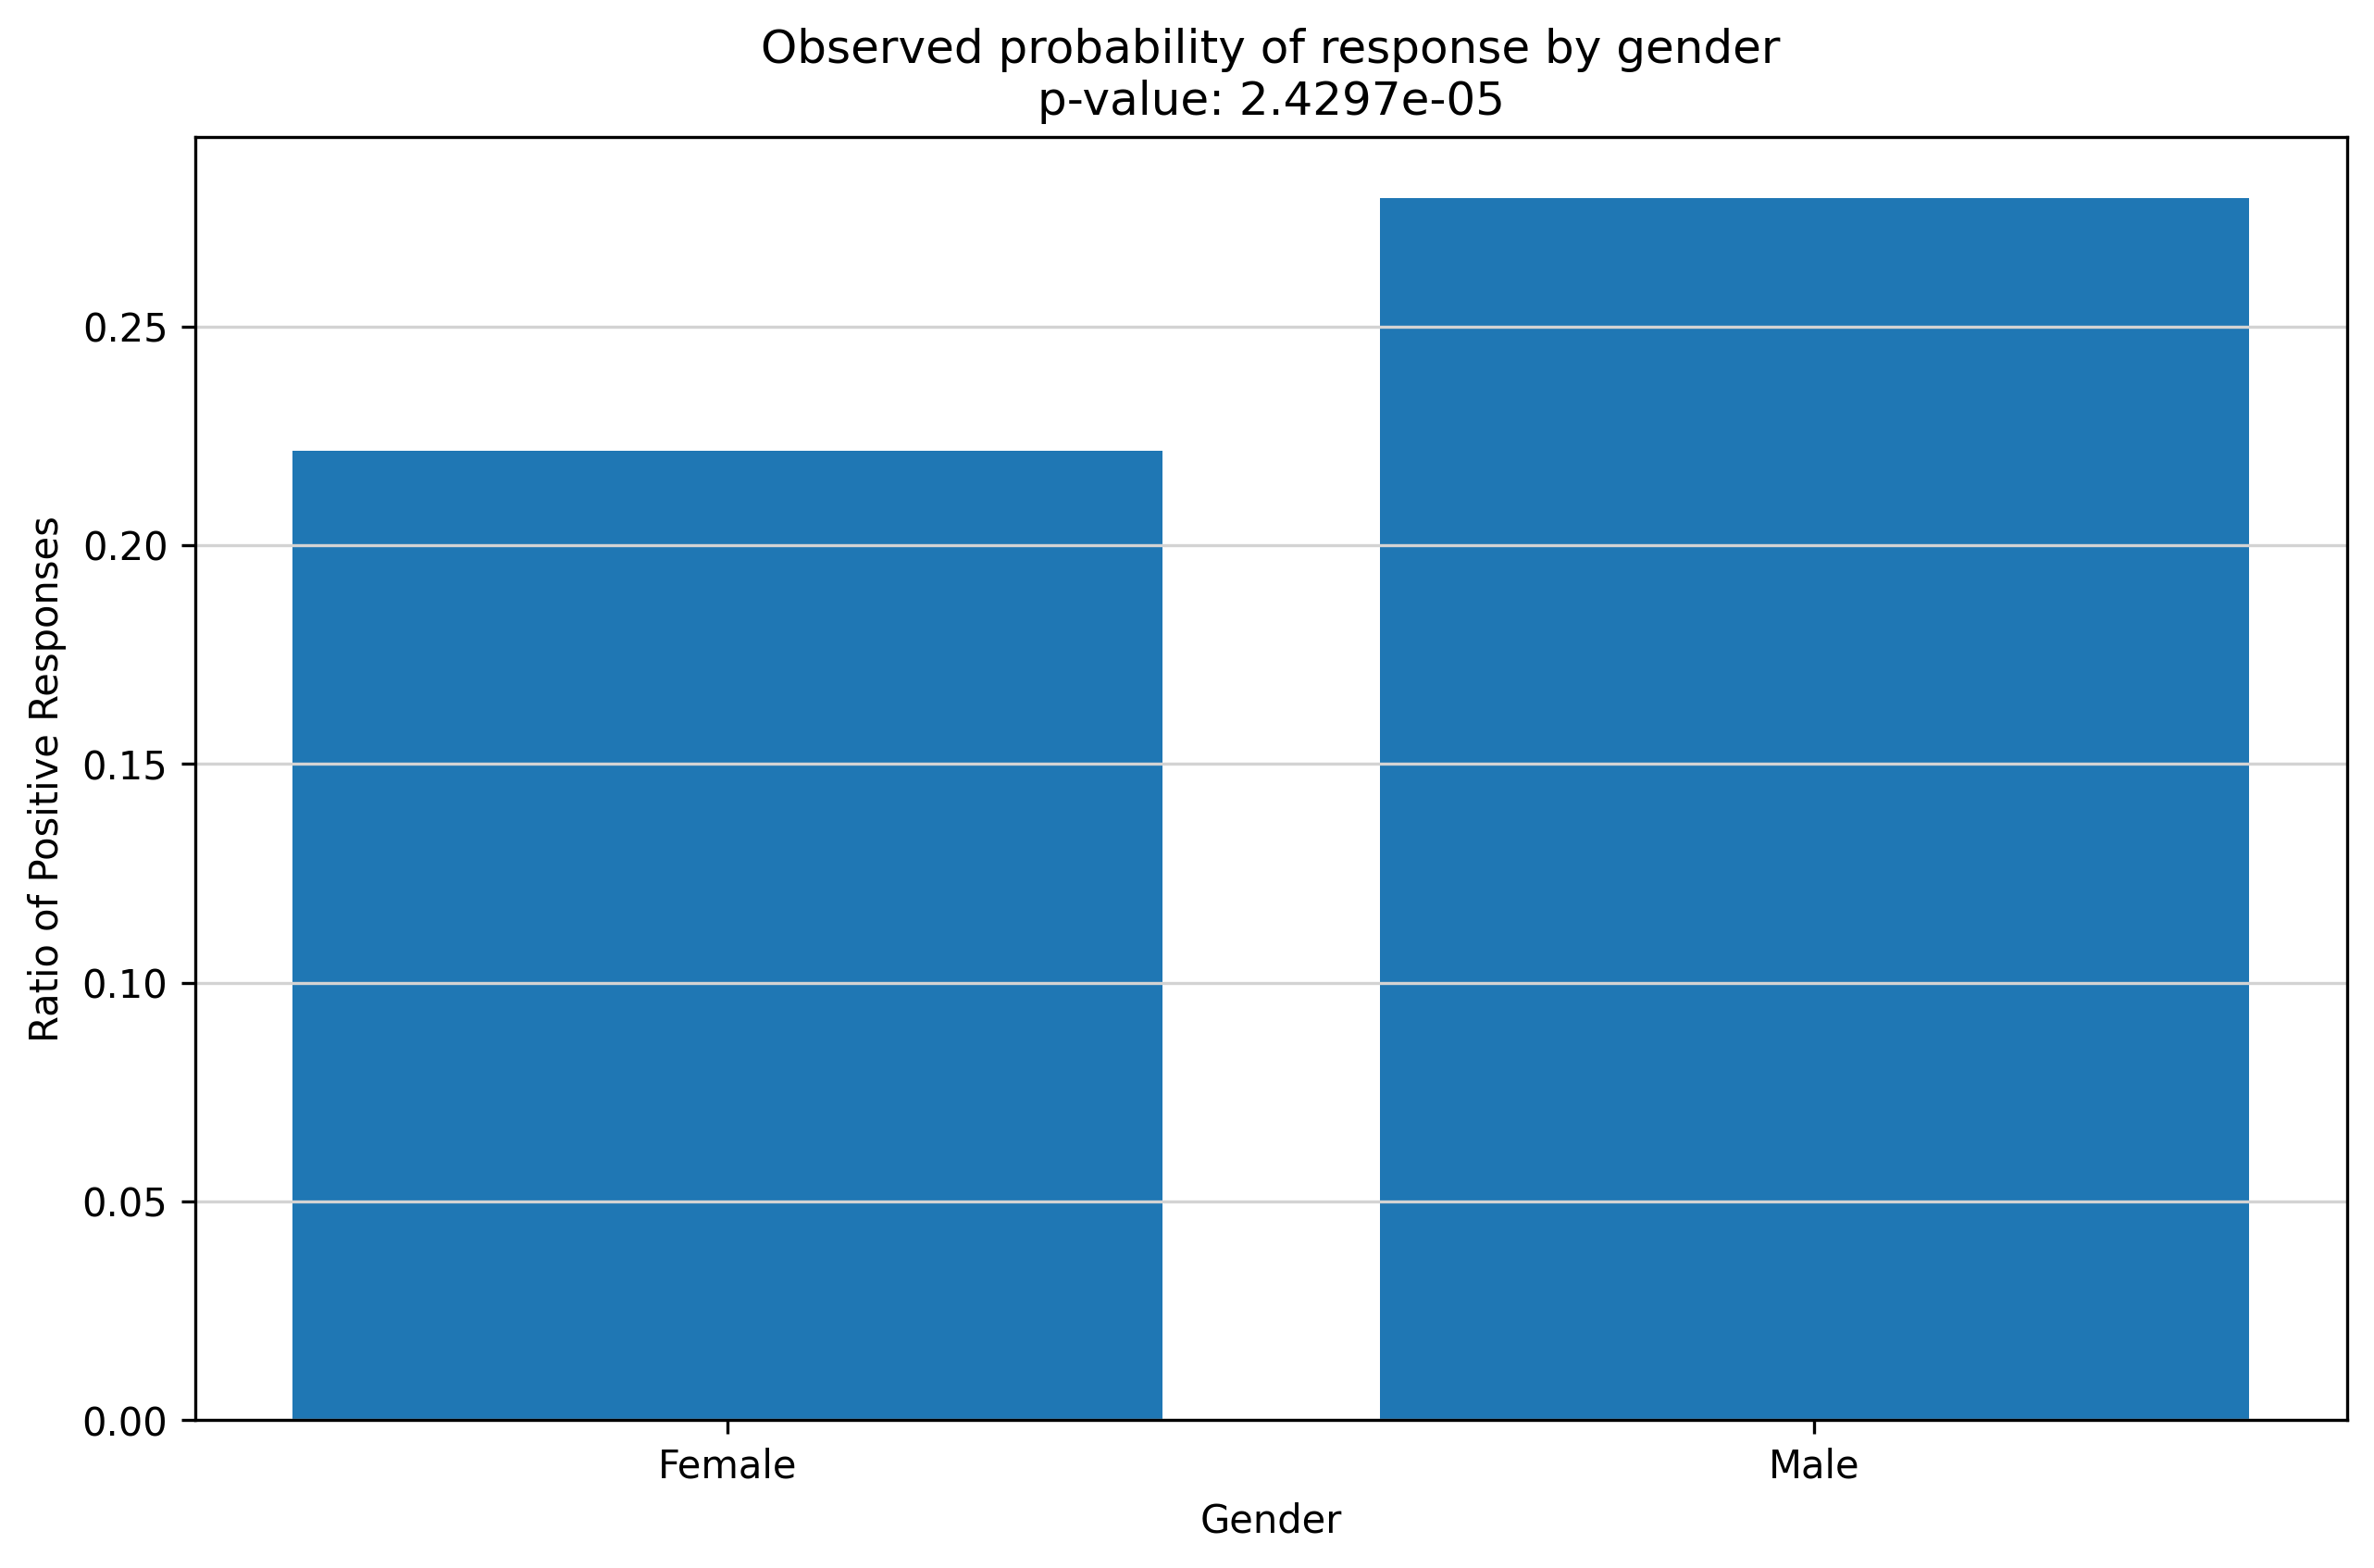

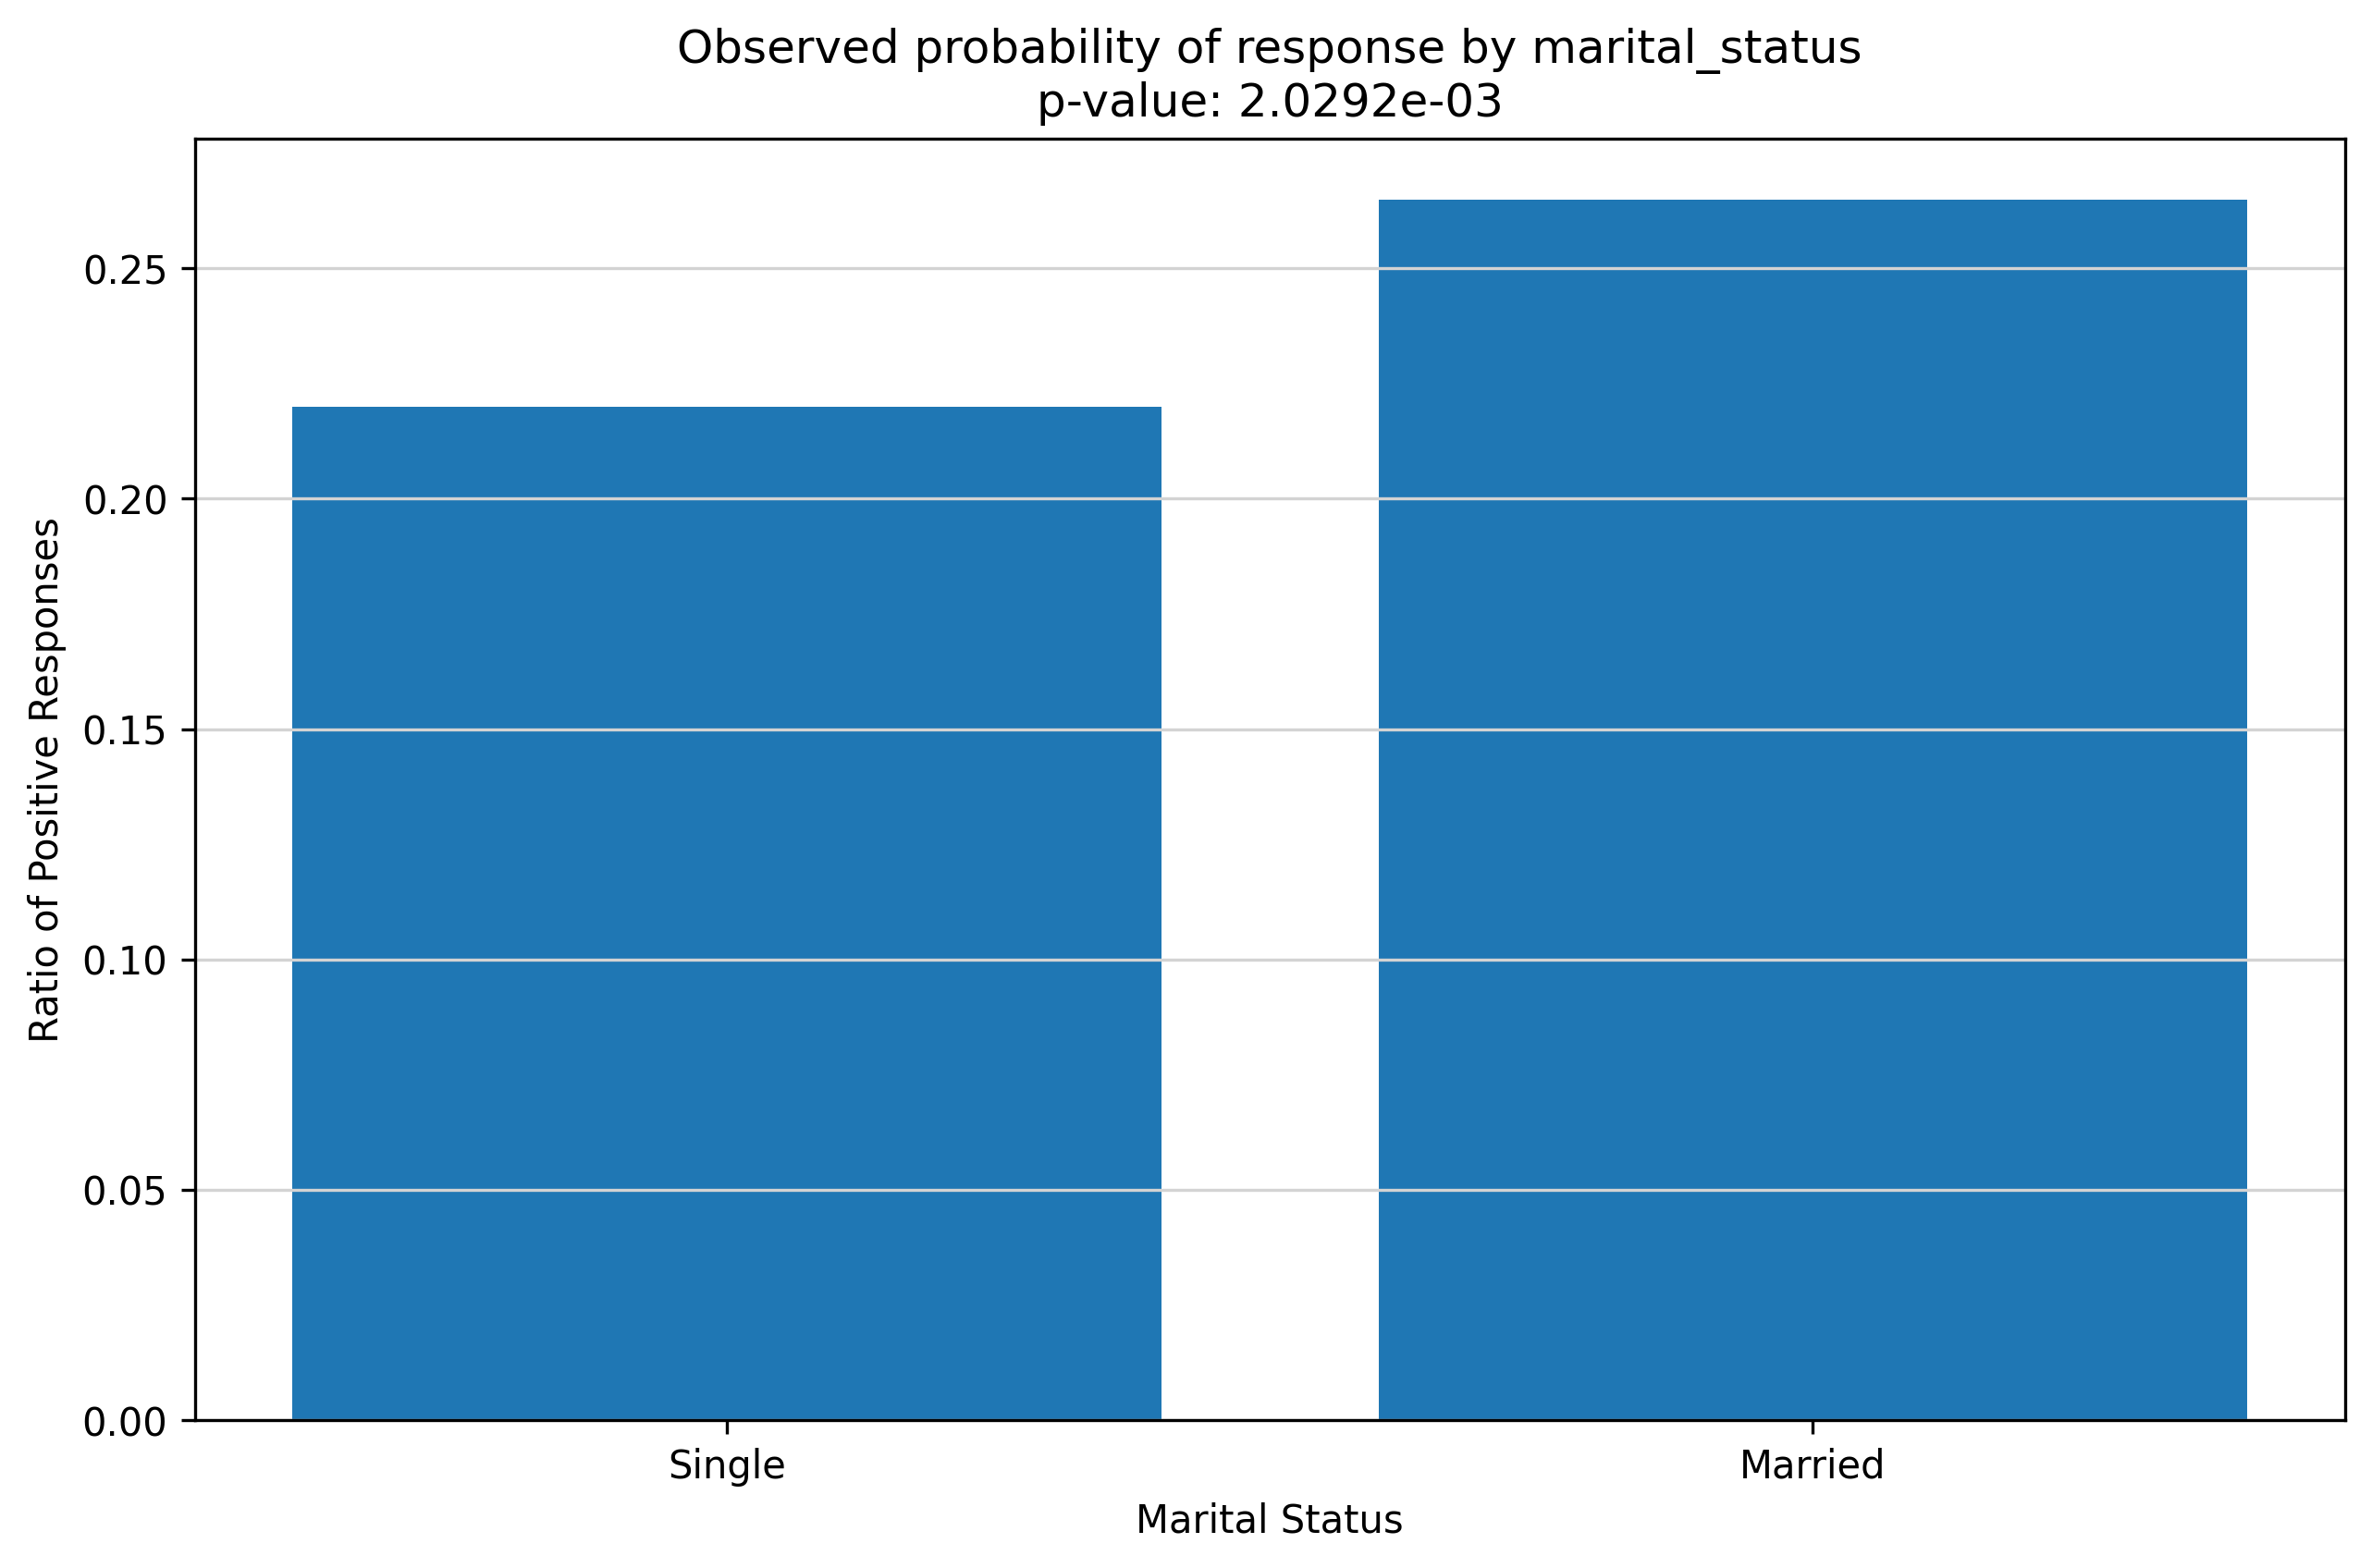

In [25]:
import matplotlib.pyplot as plt
from scipy import stats

def plot_ratio_by_category(data, col, labels):
    group0 = data[data[col] == 0]['target']
    group1 = data[data[col] == 1]['target']
    
    ratios = [len(data[(data[col] == i) & (data['target'] == 1)]) / len(data[data[col] == i]) for i in [0,1]]
    
    _, pvalue = stats.ttest_ind(group0, group1)
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    ax.bar(labels, ratios)
    ax.set_title(f'Observed probability of response by {col}\np-value: {pvalue:.4e}')
    ax.set_xlabel(col.replace('_',' ').title())
    ax.set_ylabel('Ratio of Positive Responses')
    ax.grid(axis='y', color='lightgray')
    plt.show()

plot_ratio_by_category(data, 'gender', ['Female', 'Male'])
plot_ratio_by_category(data, 'marital_status', ['Single', 'Married'])

Observed probability of response is significantly greater for men than women (gender = 1) and is significantly greater for married than single individuals (marital_status = 1).  

Check for interaction between gender and marital status in effects on response.

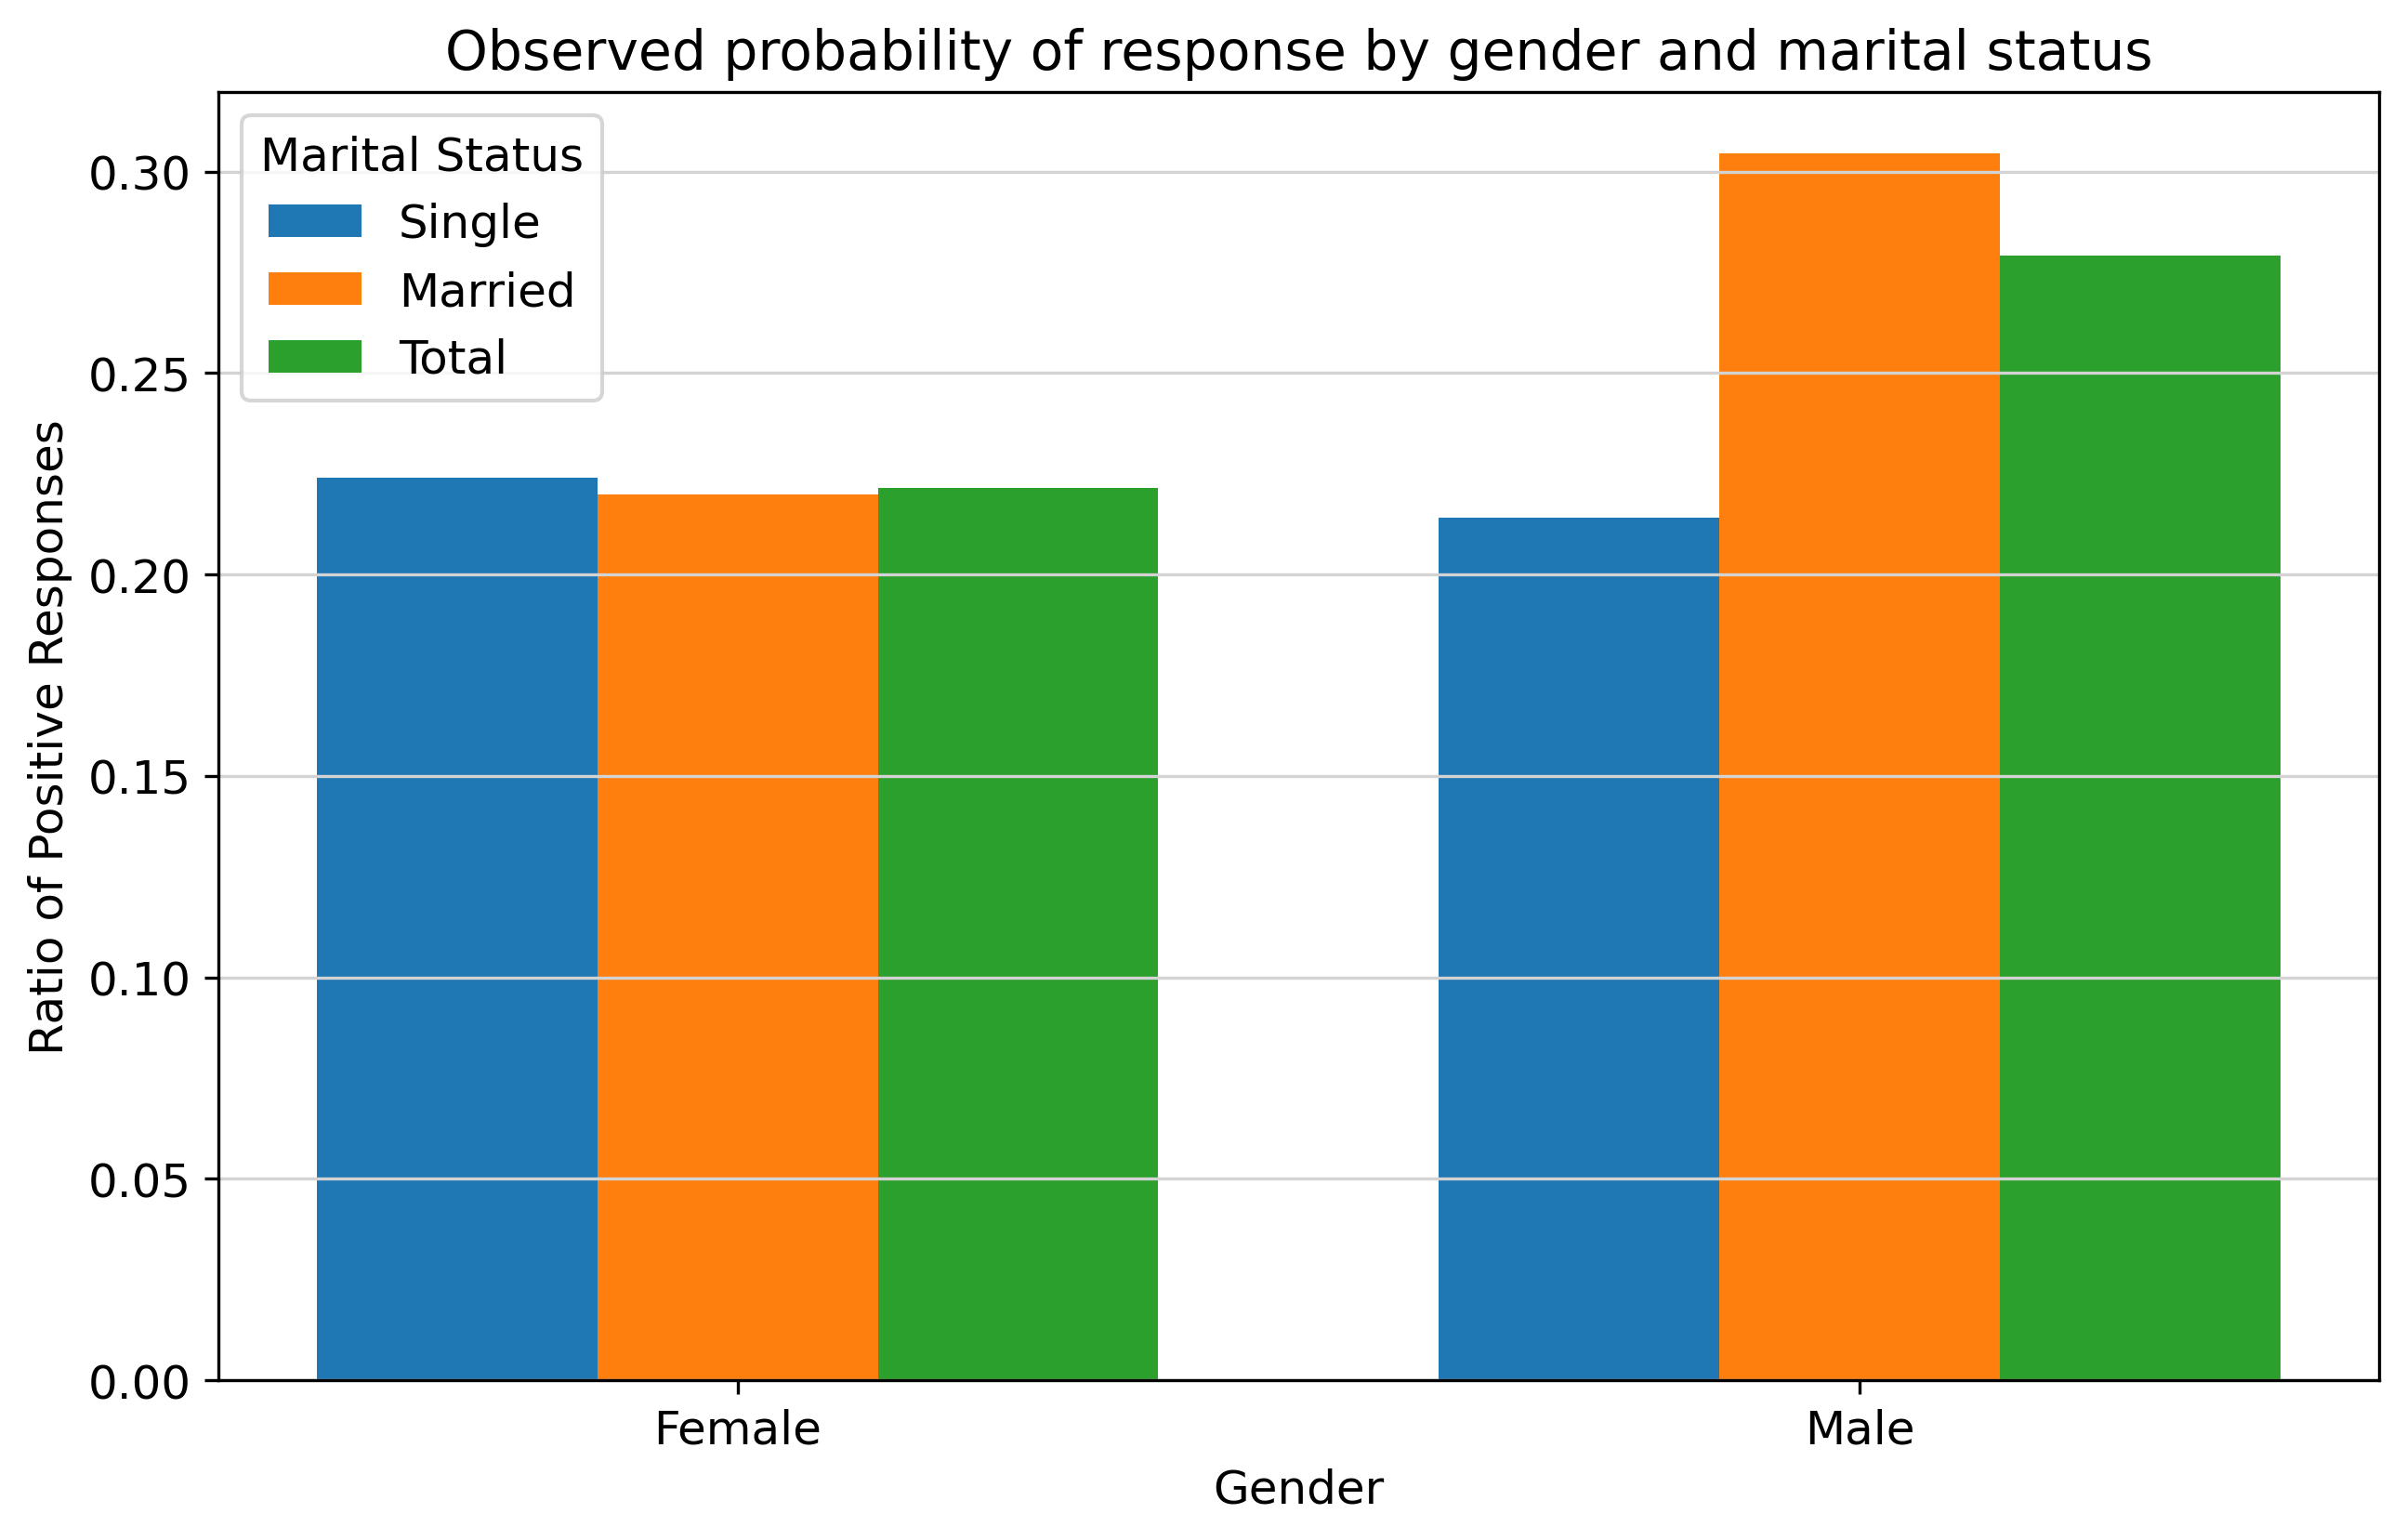

In [26]:
import matplotlib.pyplot as plt

ratios = pd.DataFrame({
    'Single': [len(data[(data['gender'] == 0) & (data['marital_status'] == 0) & (data['target'] == 1)]) / len(data[(data['gender'] == 0) & (data['marital_status'] == 0)]),
               len(data[(data['gender'] == 1) & (data['marital_status'] == 0) & (data['target'] == 1)]) / len(data[(data['gender'] == 1) & (data['marital_status'] == 0)])],
    'Married': [len(data[(data['gender'] == 0) & (data['marital_status'] == 1) & (data['target'] == 1)]) / len(data[(data['gender'] == 0) & (data['marital_status'] == 1)]),
                len(data[(data['gender'] == 1) & (data['marital_status'] == 1) & (data['target'] == 1)]) / len(data[(data['gender'] == 1) & (data['marital_status'] == 1)])],
    'Total': [len(data[(data['gender'] == 0) & (data['target'] == 1)]) / len(data[data['gender'] == 0]),
              len(data[(data['gender'] == 1) & (data['target'] == 1)]) / len(data[data['gender'] == 1])]
}, index=['Female', 'Male'])

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

x = np.arange(len(ratios.index))
width = 0.25

ax.bar(x - width, ratios['Single'], width, label='Single')
ax.bar(x, ratios['Married'], width, label='Married')
ax.bar(x + width, ratios['Total'], width, label='Total')

ax.set_title('Observed probability of response by gender and marital status', fontsize=14)
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Ratio of Positive Responses', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(ratios.index, fontsize=12)
ax.legend(title='Marital Status', fontsize=12, title_fontsize=12)
ax.grid(axis='y', color='lightgray')
ax.tick_params(axis='both', labelsize=12)

plt.show()

The Observed probability for male and for married individuals being greater than the women and single individuals is due to the variable interaction revealed in this plot. 

There is interaction between variables gender and marital status such that marital status is a significant predictor of response for men but not for women.

Evaluate Logistic Regression Model on training data with every possible combination of interaction terms and select combination with best performance to evaluate on testing data.

In [27]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
import pandas as pd
from itertools import combinations

base_features = ['age_lt80', 'age_ge80', 'dist', 'income', 'gender', 'marital_status']
interaction_terms = [
    ('age_lt80', 'dist'), ('age_lt80', 'income'), ('age_lt80', 'gender'), ('age_lt80', 'marital_status'),
    ('age_ge80', 'dist'), ('age_ge80', 'income'), ('age_ge80', 'gender'), ('age_ge80', 'marital_status'),
    ('dist', 'income'), ('dist', 'gender'), ('dist', 'marital_status'),
    ('income', 'gender'), ('income', 'marital_status'), ('gender', 'marital_status')
]

X_base = data[base_features].copy()
y = data['target']
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

results = []

for r in range(len(interaction_terms) + 1):
    for terms in combinations(interaction_terms, r):
        X_train = X_train_base.copy()
        
        for t1, t2 in terms:
            X_train[f'{t1}_{t2}'] = X_train[t1] * X_train[t2]
            
            
        model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
        y_pred_proba = model.predict(sm.add_constant(X_train))
        
        train_data = pd.DataFrame({'target': y_train, 'predicted_probs': y_pred_proba})
        train_data_sorted = train_data.sort_values('predicted_probs', ascending=False)
        
        total_pos = train_data_sorted['target'].sum()
        n_rows = len(train_data_sorted)
        cutoff_index = int(0.4 * n_rows)
        lift_at_40 = train_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100
        
        results.append({
            'interactions': terms,
            'lift_at_40': lift_at_40
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('lift_at_40', ascending=False)

print("\nBest interaction term combinations by lift at 40%:")
print(results_df.head(1))

best_terms = results_df.iloc[0]['interactions']


Best interaction term combinations by lift at 40%:
                                            interactions  lift_at_40
14779  ((age_lt80, gender), (age_lt80, marital_status...    63.85696


Model performance is measured by the percentage of total responses captured among the top 40% of customers, ranked in order of descending predicted probability of response. 

Logistic Regression Model evaluated with best combination of interaction terms on testing data results visualized by Lift Chart.

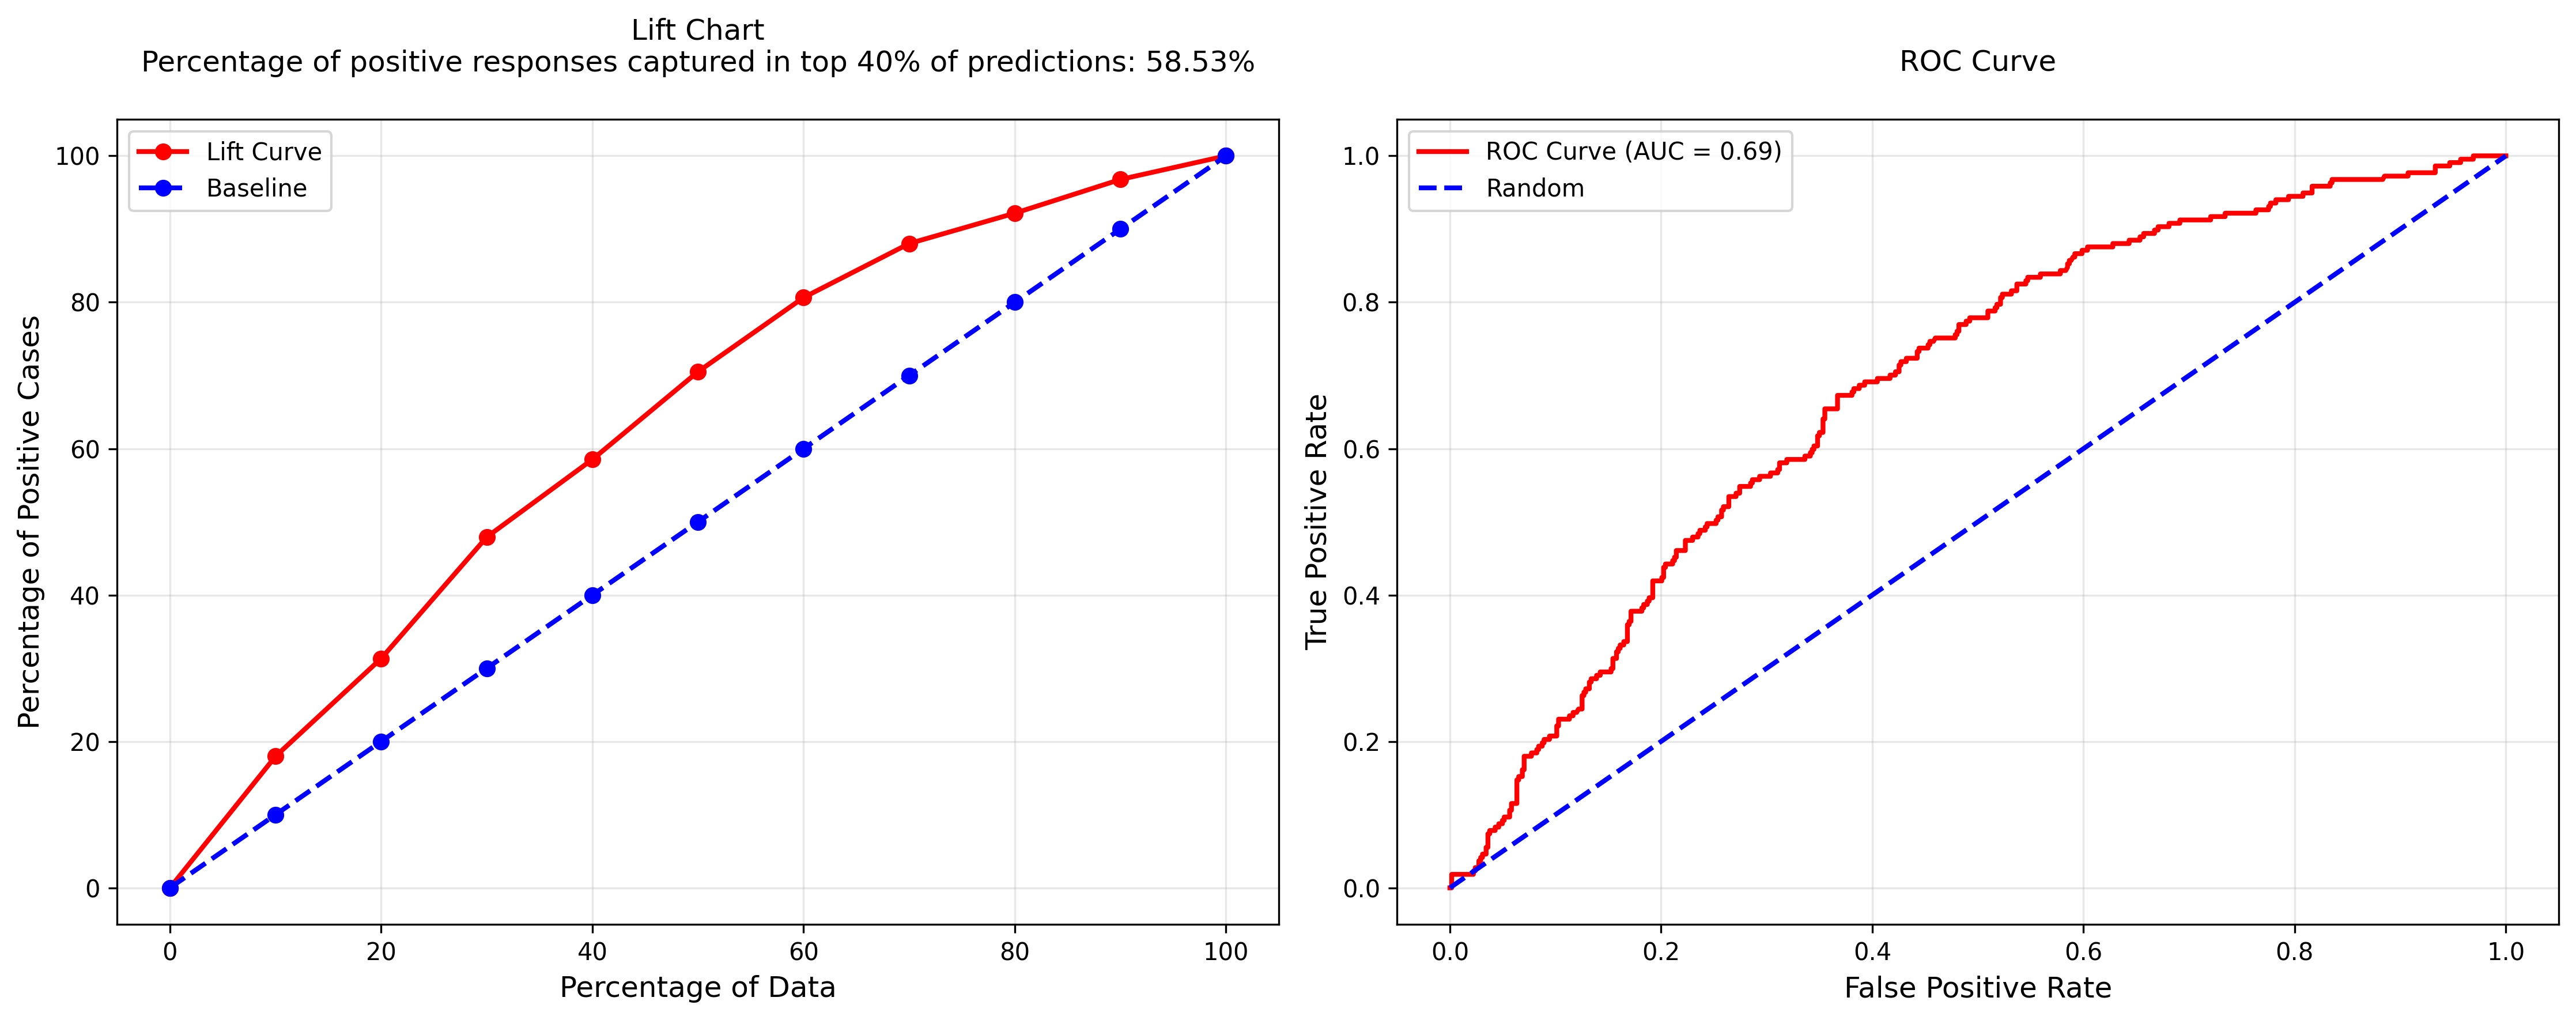

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

X_test = X_test_base.copy()
X_train_final = X_train_base.copy()

for t1, t2 in best_terms:
    X_train_final[f'{t1}_{t2}'] = X_train_base[t1] * X_train_base[t2]
    X_test[f'{t1}_{t2}'] = X_test_base[t1] * X_test_base[t2]

param_dist = {
    'C': np.logspace(start=-3, stop=2, num=6),
    'penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42, solver='liblinear', max_iter=5000),
    param_dist,
    cv=5,
    scoring='recall',
    n_iter=6,
    n_jobs=-1
)

random_search.fit(X_train_final, y_train)
best_model = random_search.best_estimator_
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)

total_pos = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)
cutoff_index = int(0.4 * n_rows)
lift_at_40 = test_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100

deciles = np.linspace(0, n_rows, 11, dtype=int)
lift_curve = [test_data_sorted.iloc[:i]['target'].sum() / total_pos * 100 for i in deciles]
baseline = np.linspace(0, 100, 11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=300)

ax1.plot(baseline, lift_curve, marker='o', label='Lift Curve', color='red', linewidth=2)
ax1.plot(baseline, baseline, linestyle='--', marker='o', label='Baseline', color='blue', linewidth=2)
ax1.set_xlabel('Percentage of Data', fontsize=12)
ax1.set_ylabel('Percentage of Positive Cases', fontsize=12)
ax1.set_title(f'Lift Chart\nPercentage of positive responses captured in top 40% of predictions: {lift_at_40:.2f}%', 
          fontsize=12, pad=20)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('white')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='red', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='blue', linestyle='--', linewidth=2, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=12, pad=20)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('white')

plt.tight_layout()
plt.show()

If this model were used on in future advertising campaigns assuming that the population of potential customers does not change, we can expect to yield ~60% of the responses by advertising to 40% of the potential customers.